In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

2024-07-13 19:36:03.353364: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Problem One: Classifying fully connected layers

In [2]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        self.optimizer = optimizer
        self.HW = 0
        self.HB = 0

    def forward(self, X):
        self.Z = X
        self.A = X @ self.W + self.B
        return self.A

    def backward(self, dA):
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        self.dZ = dA @ self.W.T
        self = self.optimizer.update(self)
        return self.dZ

## Problem Two: Classifying the initialization method

In [3]:
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(1, n_nodes2)

## Problem Three: Classifying optimization methods

In [4]:
class SGD:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW / len(layer.Z)
        layer.B -= self.lr * layer.dB / len(layer.Z)
        return layer

## Problem Four: Classifying activation functions

In [5]:
class Sigmoid:

    def forward(self, A):
        self.A = A
        Z = 1 / (1 + np.exp(-self.A))
        return Z

    def backward(self, dZ):
        dA = dZ * ((1 / (1 + np.exp(-self.A))) - (1 / (1 + np.exp(-self.A)))**2)
        return dA

In [6]:
class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(self.A)

    def backward(self, dZ):
        return dZ * (1 - np.tanh(self.A)**2)

In [7]:
class softmax:
    def forward(self, A):
        exp_A = np.exp(A - np.max(A, axis=1, keepdims=True))
        return exp_A / np.sum(exp_A, axis=1, keepdims=True)

    def backward(self, Z, y):
        dA = Z - y
        loss = -np.sum(y * np.log(Z + 1e-7)) / len(y)
        return dA, loss

## Problem Five: ReLU class creation

In [8]:
class ReLU:
    def forward(self, A):
        self.A = A
        return np.maximum(0, A)

    def backward(self, dZ):
        return dZ * (self.A > 0)

## Problem: Six Initial value of weight

In [9]:
class XavierInitializer:
    def __init__(self, sigma=None):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return np.zeros((1, n_nodes2))

In [10]:
class HeInitializer:
    def __init__(self, sigma=None):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2 / n_nodes1)
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return np.zeros((1, n_nodes2))

## Problem Seven: Optimization method

In [11]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.HW += layer.dW * layer.dW
        layer.HB += layer.dB * layer.dB
        delta = 1e-7
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.HW) + delta) / len(layer.Z)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.HB) + delta) / len(layer.Z)
        return layer

## Problem Eight: Class completion

In [12]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0] / self.batch_size).astype(int)

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = (item + 1) * self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        result = self.__getitem__(self._counter)
        self._counter += 1
        return result

In [13]:
class ScratchDeepNeuralNetworkClassifier:
    def __init__(self, verbose=False, epoch=1, optimizer=SGD, initializer=HeInitializer, activater=ReLU):
        self.verbose = verbose
        self.batch_size = 20
        self.n_features = 784
        self.n_nodes1 = 400
        self.n_nodes2 = 200
        self.n_output = 10
        self.sigma = 0.02
        self.lr = 0.5
        self.epoch = epoch
        self.optimizer = optimizer
        self.initializer = initializer
        self.activater = activater

    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_train = []
        self.loss_val = []
        optimizer = self.optimizer(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), optimizer)
        self.activation1 = self.activater()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), optimizer)
        self.activation2 = self.activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), optimizer)
        self.activation3 = softmax()

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            for mini_X, mini_y in get_mini_batch:
                A1 = self.FC1.forward(mini_X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                dA3, loss = self.activation3.backward(Z3, mini_y)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1)

            if self.verbose:
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                self.loss_train.append(self.activation3.backward(Z3, y)[1])

                if X_val is not None:
                    A1 = self.FC1.forward(X_val)
                    Z1 = self.activation1.forward(A1)
                    A2 = self.FC2.forward(Z1)
                    Z2 = self.activation2.forward(A2)
                    A3 = self.FC3.forward(Z2)
                    Z3 = self.activation3.forward(A3)
                    self.loss_val.append(self.activation3.backward(Z3, y_val)[1])

    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return np.argmax(Z3, axis=1)


## Problem Nine: Learning and estimation

In [14]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape and normalize the data
X_train = X_train.reshape(-1, 784).astype(np.float64) / 255
X_test = X_test.reshape(-1, 784).astype(np.float64) / 255

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# One-hot encoding of the labels after splitting
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])

In [15]:
SDNN = ScratchDeepNeuralNetworkClassifier(verbose=True, epoch=10, optimizer=AdaGrad, initializer=HeInitializer, activater=ReLU)

SDNN.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

In [16]:
pred = SDNN.predict(X_val)
accuracy_score(y_val, pred)

0.9811666666666666

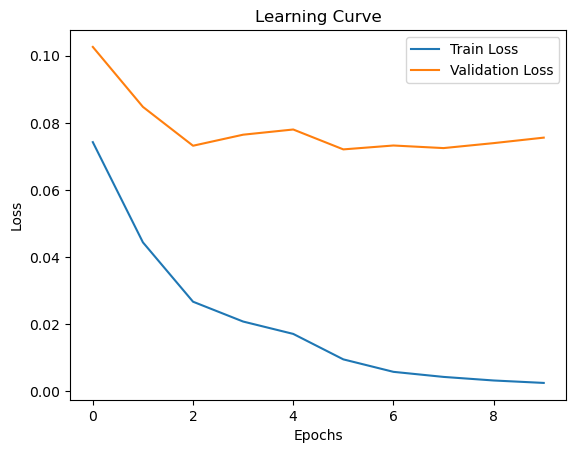

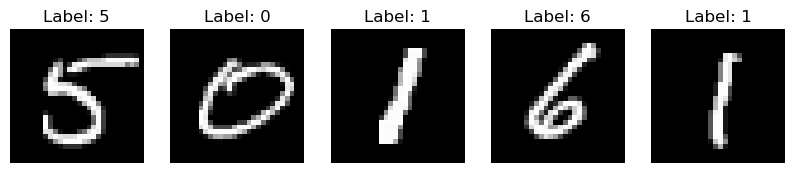

In [17]:
# Plot Learning Curve
plt.plot(SDNN.loss_train, label='Train Loss')
plt.plot(SDNN.loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Display MNIST Images
def display_mnist_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

display_mnist_images(X_train.reshape(-1, 28, 28), y_train, num_images=5)